# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 29.10.2021

Мягкий дедлайн: 23:59MSK 10.11.2021 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13.11.2021

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=11)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=11)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [3]:
from sklearn import svm
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from time import time
from tqdm import tqdm
import seaborn as sns

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=11)

c_array = np.logspace(-1, 4, 40)
auc_roc_val = []
best_c = c_array[0]
best_roc_val = 0

for c in tqdm(c_array):
    svc = svm.SVC(C=c).fit(X_train, y_train)
    svc_pred = svc.decision_function(X_val)
    temp_roc = roc_auc_score(y_val, svc_pred)
    auc_roc_val.append(temp_roc)
    if temp_roc > best_roc_val:
        best_roc_val = temp_roc
        best_c = c
#     print('C:', c, 'SVC ROC-AUC:', temp_roc)

100%|██████████| 40/40 [01:18<00:00,  1.95s/it]


In [5]:
svc = svm.SVC(max_iter=100000, C=best_c).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
roc_test = roc_auc_score(y_test, svc_pred)


На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


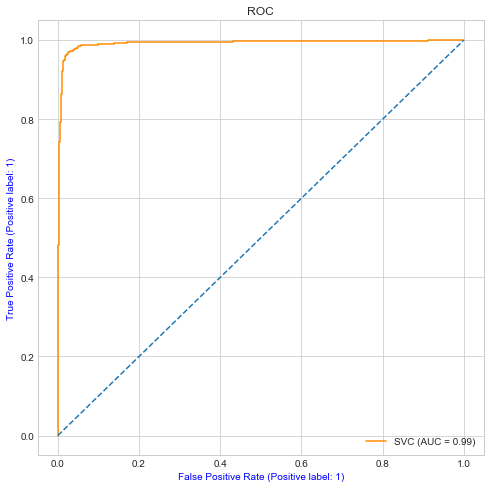

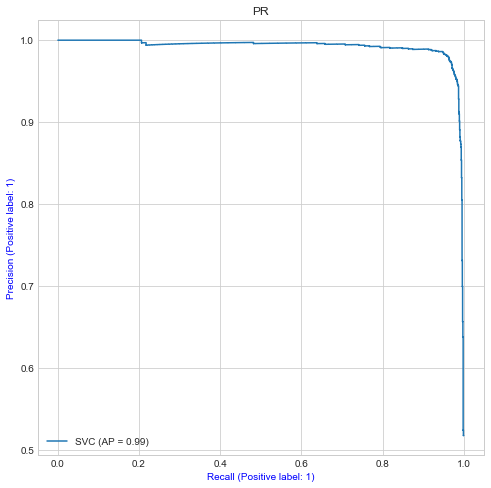

AUC-ROC = 0.99231
Второй метод
AUC-PR = 0.99211


In [6]:
# Обучим модельку
svc = svm.SVC(C = best_c).fit(X_train, y_train)

# ROC plot
plt.style.use('seaborn-whitegrid')
roc = plot_roc_curve(svc, X_test, y_test, color='darkorange')
plt.title('ROC')
plt.plot([0, 1], [0, 1], linestyle='--')

roc.ax_.xaxis.label.set_color('b')
roc.ax_.yaxis.label.set_color('b')
roc.figure_.set_size_inches(8, 8)

# Считаем AUC-ROC - двумя способами
y_pred = svc.decision_function(X_test)
roc_sc2 = roc_auc_score(y_test, y_pred)


#PR plot
pr = plot_precision_recall_curve(svc, X_test, y_test)
plt.title('PR')
pr.ax_.xaxis.label.set_color('b')
pr.ax_.yaxis.label.set_color('b')
pr.figure_.set_size_inches(8, 8)

# Считаем AUC-PR - двумя способами
pr_sc2 = average_precision_score(y_test, y_pred)
plt.show()
print("AUC-ROC = %.5f" % roc_sc2)
print("Второй метод")
print("AUC-PR = %.5f" % pr_sc2)


# источник https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

0.00035564803062231287


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


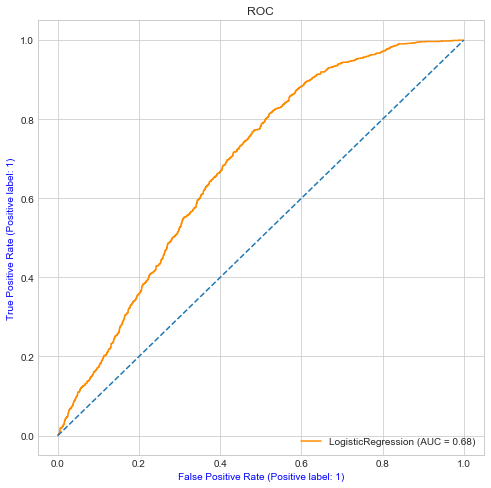

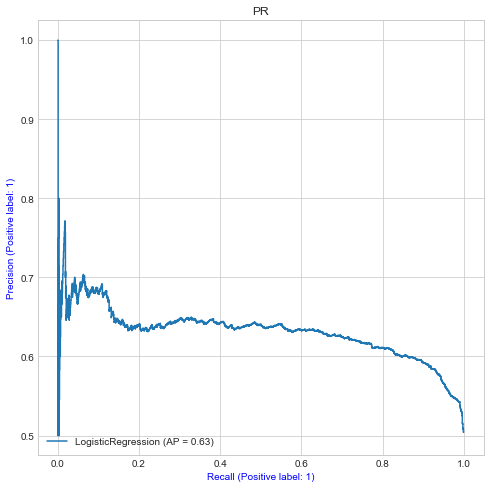

AUC-ROC = 0.68307
Второй метод
AUC-PR = 0.63145


In [7]:
c_array_lr = np.logspace(-5, -1, 50)
auc_roc_val = []
best_c_lr = c_array[0]
best_roc_val = 0

for c in c_array_lr:
    lr = LogisticRegression(max_iter=100000, C=c).fit(X_train, y_train)
    lr_pred = lr.decision_function(X_val)
    temp_roc = roc_auc_score(y_val, lr_pred)
    auc_roc_val.append(temp_roc)
    if temp_roc > best_roc_val:
        best_roc_val = temp_roc
        best_c_lr = c

print(best_c_lr)
lr = LogisticRegression(max_iter=100000, C=best_c_lr).fit(X_train, y_train)

# ROC plot
plt.style.use('seaborn-whitegrid')
roc = plot_roc_curve(lr, X_test, y_test, color='darkorange')
plt.title('ROC')
plt.plot([0, 1], [0, 1], linestyle='--')

roc.ax_.xaxis.label.set_color('b')
roc.ax_.yaxis.label.set_color('b')
roc.figure_.set_size_inches(8, 8)

# Считаем AUC-ROC - двумя способами
y_pred = lr.decision_function(X_test)
roc_sc2 = roc_auc_score(y_test, y_pred)


#PR plot
pr = plot_precision_recall_curve(lr, X_test, y_test)
plt.title('PR')
pr.ax_.xaxis.label.set_color('b')
pr.ax_.yaxis.label.set_color('b')
pr.figure_.set_size_inches(8, 8)

# Считаем AUC-PR - двумя способами
pr_sc2 = average_precision_score(y_test, y_pred)
plt.show()
print("AUC-ROC = %.5f" % roc_sc2)
print("Второй метод")
print("AUC-PR = %.5f" % pr_sc2)

#### SVM лучше для AUC_ROC, а LR лучше для определения вероятностей####

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [8]:
X, y = make_classification(n_samples=333, n_features=2, n_informative=2, n_redundant=0, random_state=11)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

svc = svm.SVC(kernel='linear', max_iter=100000, C=best_c).fit(X_train, y_train)
support_vectors = svc.support_vectors_

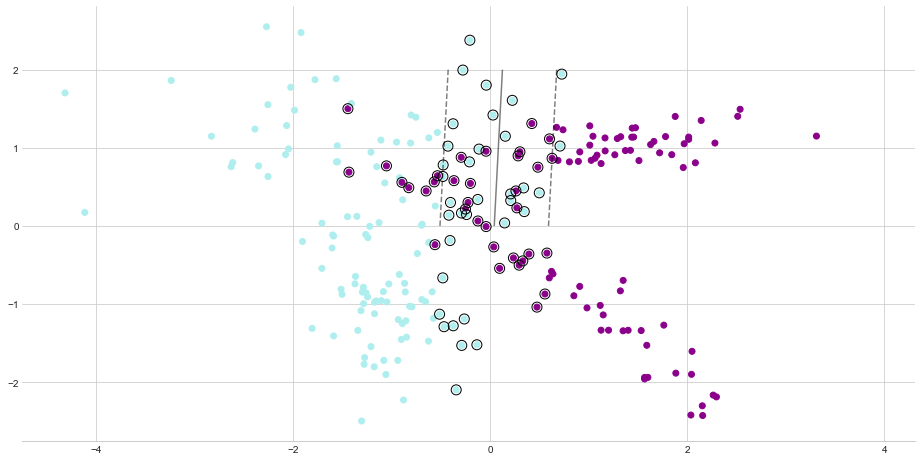

In [9]:
fig, ax = plt.subplots(figsize=(16, 8))

# Удалим верхнюю и правую границу
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Создадим сетку
xx = np.linspace(-1, X_train.max() + 1, len(X_train))
yy = np.linspace(0, max(y_train) + 1, len(y_train))
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# Определим цвета
colors = y_train
colors = np.where(colors==1, '#8B008B', '#AFEEEE')

# Построение графика набора данных
ax.scatter(X_train[:,0], X_train[:,1], c=colors)

# Получение разделяющей гиперплоскости
Z = svc.decision_function(xy).reshape(XX.shape)

# Рисунок границ решения и запасов
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# Выделение опорных векторов окружностями
ax.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
plt.show()

# Источник: https://medium.com/nuances-of-programming/%D0%BC%D0%B5%D1%82%D0%BE%D0%B4-%D0%BE%D0%BF%D0%BE%D1%80%D0%BD%D1%8B%D1%85-%D0%B2%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D0%BE%D0%B2-%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%D1%8B-%D0%BD%D0%B0-python-655455a2fd3b

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

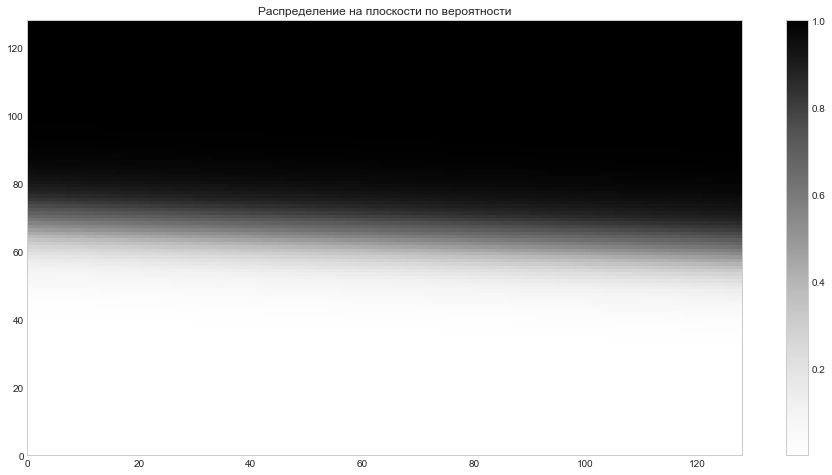

In [10]:
xs = np.linspace(-5, 5, 128)
ys = np.linspace(-5, 5, 128)
plot = np.ones(shape=(128, 128))

clf = svm.SVC(kernel='linear', probability=True)
clf.fit(X, y)

for i in range(128):
    for j in range(128):
        box =  np.array([[xs[i], ys[j]]])
        box = clf.predict_proba(box)
        plot[i, j] = box[0, 1]

plt.figure(figsize=(16, 8))
plt.title("Распределение на плоскости по вероятности")        
plt.pcolormesh(plot)
plt.colorbar()
plt.show()

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [11]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

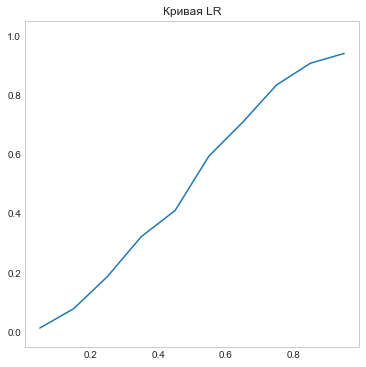

In [12]:
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression(C = best_c_lr, penalty='l2')
clf.fit(X_train, y_train)
preds_LR = clf.predict_proba(X_test)
plot_calibration_curve(y_test, preds_LR[:, 1])
plt.title('Кривая LR')
plt.show()

/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


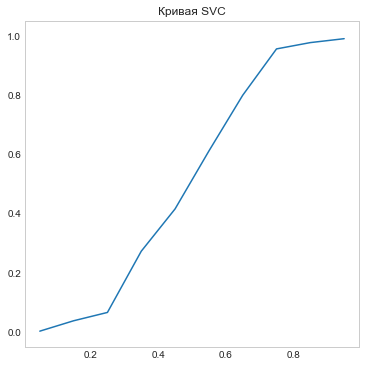

In [13]:
svc = svm.SVC(max_iter=100000, C=best_c).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test) 
# preds_SVM = clf.decision_function(X_test)
svc_pred = 1/(1 + np.exp(-svc_pred))
plot_calibration_curve(y_test, svc_pred)
plt.title('Кривая SVC')
plt.show()

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


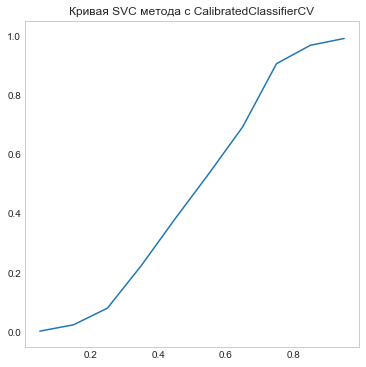

In [14]:
svc = svm.SVC(max_iter=100000, C=best_c)
svc = CalibratedClassifierCV(svc)
svc.fit(X_train, y_train)
svc_pred = svc.predict_proba(X_test) 
# preds_SVM = clf.decision_function(X_test)
# svc_pred = 1/(1 + np.exp(-svc_pred))
plot_calibration_curve(y_test, svc_pred[:, 1])
plt.title('Кривая SVC метода c CalibratedClassifierCV')
plt.show()

### Ответ: Крямая начала выглядеть более гладкой и больше похожа на идеальную (диагональную)###

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [15]:
#your code here

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [16]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [17]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [18]:
df = df.drop(columns='duration')
df.y = df.y.replace({'no':0, 'yes':1})
df.y

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41188, dtype: int64

### в файле _bank-additional-names.txt_ обозначение столбцов. ###
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: В нашем случае очень большой перевес в сторону людей которые соглашаются.Из лекции мы знаем, что в таком случае нежелательно использовать AUC-ROC

In [19]:
X = df.loc[:, 'age':'nr.employed']
y = df['y']

In [20]:
categorical = X.dtypes[X.dtypes == 'object'].index.tolist()
numerical = X.dtypes[X.dtypes != 'object'].index.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=777)

column_transformer = ColumnTransformer([
    ('ore', OrdinalEncoder(), categorical),
    ('scaling', StandardScaler(), numerical)
])

pipeline = Pipeline(steps=[
    ('ore_and_scaling', column_transformer), 
    ('LR', LogisticRegression(penalty='l2', C=best_c_lr, max_iter=1000))
])


start = time()
lr = pipeline.fit(X_train, y_train)
print(time() - start, ' is taken.')

0.14423298835754395  is taken.


In [21]:
pred = lr.decision_function(X_test)
auc_pr = average_precision_score(y_test, pred)
print("AUC-PR: ", auc_pr)

AUC-PR:  0.4273620942253927


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [22]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numerical)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer), 
    ('LR', LogisticRegression(penalty='l2', C=best_c_lr, max_iter=1000))
])
start = time()
lr = pipeline.fit(X_train, y_train)
print(time() - start, ' is taken.')

0.1435718536376953  is taken.


In [23]:
pred = lr.decision_function(X_test)
auc_pr = average_precision_score(y_test, pred)
print("AUC-PR:", auc_pr)

AUC-PR: 0.42758617966331325


### Ответ: Улучшилось качество, но и время работы тоже увеличилось.###

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [24]:
class CountTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical):
        self.categorical = categorical
        self.cat_dict = dict()
        
    def fit(self, X_train, y_train):
        for col in self.categorical:
            self.cat_dict[col] = (pd.concat([X_train[col], y], axis=1).groupby(col).mean())['y'].to_dict()
            
    def transform(self, X_test):
        res = X_test.copy()
        for col in self.cat_dict:
            res[col].replace(self.cat_dict[col], inplace = True)
        
        return res

In [25]:
def calculate_PR(categorical, CountTransformer, X_train, y_train, X_test, y_test, C=dict(), gm=1, base_C = 1):
    scaler = StandardScaler()
    count_transfor = CountTransformer(categorical)
    count_transfor.fit(X_train, y_train)
    X_train_tr = count_transfor.transform(X_train)
    X_test_tr = count_transfor.transform(X_test)
    
    X_train_tr = scaler.fit_transform(X_train_tr)
    X_test_tr = scaler.transform(X_test_tr)
    
    lr = LogisticRegression(penalty='l2')
    start = time()
    lr.fit(X_train_tr, y_train)
    print(time() - start, " is taken")
    auc_roc = average_precision_score(y_test, lr.decision_function(X_test_tr))
    return auc_roc

In [26]:
pr = calculate_PR(categorical, CountTransformer, X_train, y_train, X_test, y_test)
print('AUC-PR: ', pr)

0.06208682060241699  is taken
AUC-PR:  0.45259851414525054


### Ответ: Ускорение работы кодировки во много раз###

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [27]:
categorical

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [28]:
class CountTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical):
        self.categorical = categorical
        self.cat_dict = dict()
        
    def fit(self, X_train, y_train):
        for col in self.categorical:
            elem = pd.concat([X_train[col], y], axis = 1)
            elem = elem.groupby(col).mean()['y']
            sz = X_train[col].unique().shape[0]
            elem += np.random.normal(size=sz)
            elem = elem.to_dict()
            self.cat_dict[col] = elem
    def transform(self, X_test):
        res = X_test.copy()
        for col in self.cat_dict:
            res[col].replace(self.cat_dict[col], inplace = True)
        
        return res

In [29]:
pr = calculate_PR(categorical, CountTransformer, X_train, y_train, X_test, y_test)
print('AUC-PR: ', pr)

0.05325007438659668  is taken
AUC-PR:  0.4386195278355383


### Ответ: Качество модельки незначительно дергается ###

__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [30]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_dict = dict()
month_rev_dict = dict()
month_num = 1
for month in months:
    month_dict[month_num] = month
    month_rev_dict[month] = month_num
    month_num += 1

class CountTransformerFirstMethod(BaseEstimator, TransformerMixin):
    def __init__(self, categorical):
        self.categorical = categorical
        self.cat_dict = dict()
        
    def fit(self, X_train, y_train):
        X_train_copy = X_train.copy()
        
        X_train_copy['month'] = X_train_copy['month'].replace(month_rev_dict)
        X_train_copy.sort_values(by='month')
        
        for col in self.categorical:
            self.cat_dict[col] = dict()
            for categ in X_train_copy[col].unique():
                low_bound = X_train_copy[X_train_copy[col] == categ].month.iloc[0]
                mask = X_train_copy[np.logical_and(X_train_copy[col] == categ , X_train_copy['month'] >= low_bound)].index
                if (col == 'month'):
                    categ = month_dict[categ]
                self.cat_dict[col][categ] = np.mean(y_train.loc[mask])

    def transform(self, X_test):
        res = X_test.copy()
        for col in self.cat_dict:
            res[col].replace(self.cat_dict[col], inplace=True)

        return res


In [31]:
pr = calculate_PR(categorical, CountTransformerFirstMethod, X_train, y_train, X_test, y_test)
print(pr)

0.06518292427062988  is taken
0.4455495952969156


А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [32]:
class CountTransformerGL(BaseEstimator, TransformerMixin):
    def __init__(self, categorical):
        self.categorical = categorical
        self.cat_dict = dict()
        
    def fit(self, X_train, y_train, C=dict(), gm=1, base_C=1):
        X_tr = X_train.copy()
        for col in self.categorical:
            self.cat_dict[col] = dict()
            for cat in X_tr[col].unique():
                mask = X_tr[(X_tr[col] == cat)].index
                if not (col in C):
                    C[col] = base_C
                self.cat_dict[col][cat] = (np.sum(y_train.loc[mask]) + C[col] * gm) / (mask.shape[0] + C[col])

    def transform(self, X_test):
        res = X_test.copy()
        for col in self.cat_dict:
            res[col].replace(self.cat_dict[col], inplace=True)

        return res

In [33]:
pr = calculate_PR(categorical, CountTransformerGL, X_train, y_train, X_test, y_test, C=dict(), gm=1, base_C=1)
print(pr)

0.06801199913024902  is taken
0.45249027271248105


__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [34]:
numerical.remove('age')
categorical.append('age')
pr = calculate_PR(categorical, CountTransformerGL, X_train, y_train, X_test, y_test, C=dict(), gm=1, base_C=1)
print(pr)
print('Количество уникального возраста в df: ', len(df['age'].unique()))

0.06094217300415039  is taken
0.4524237834465631
Количество уникального возраста в df:  78


### Ответ: различий почти нет, результат совсем немного лучше ###

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [35]:
categorical.remove('month')
categorical.remove('day_of_week')

numerical.append('month')
numerical.append('day_of_week')


month_num = 0
days_in_num = dict()
for month in ['mon', 'tue', 'wed', 'thu', 'fri']:
    days_in_num[month] = month_num
    month_num += 1


month_rev_dict = dict()
month_num = 0
for month in months:
    month_rev_dict[month] = month_num
    month_num += 1

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
X_train_copy.day_of_week.replace(days_in_num, inplace=True)
X_train_copy.month.replace(month_rev_dict, inplace=True)
X_test_copy.day_of_week.replace(days_in_num, inplace=True)
X_test_copy.month.replace(month_rev_dict, inplace=True)

pr = calculate_PR(categorical, CountTransformerGL, X_train_copy, y_train, X_test_copy, y_test, C=dict(), gm=1, base_C=1)
print(pr)

0.06817388534545898  is taken
0.44800218190354113


### Ответ: Качество сильно улучшилось###

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [36]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [37]:
categorical.remove('age')
numerical.append('age')
numerical.remove('month')
categorical.append('month')
numerical.remove('day_of_week')
categorical.append('day_of_week')

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [38]:
print(categorical)
print(numerical)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month', 'day_of_week']
['campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'age']


In [39]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numerical)
])
X_train_copy = column_transformer.fit_transform(X_train)
X_test_copy = column_transformer.transform(X_test)
print('Количество признаков:', X_train_copy.shape[1])

Количество признаков: 62


In [40]:
lr = LogisticRegression(max_iter=100000).fit(X_train_copy, y_train)
pred = lr.decision_function(X_test_copy)
auc = average_precision_score(y_test, pred)
print("AUC-PR:", auc)

AUC-PR: 0.44780091060381233


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [41]:
def make40s(X, coef):
    res = pd.DataFrame(X, columns=coef)
    res = res.sort_index(axis=1, ascending=False)
    res = res.loc[:, :res.columns[39]]
    return res

coef = lr.coef_.reshape(-1)
X_test_40 = make40s(X_test_copy, coef)
X_train_40 = make40s(X_train_copy, coef)

clf = LogisticRegression(max_iter=1000)
display(X_test)
clf.fit(X_train_40, y_train)
pr = average_precision_score(y_test, clf.decision_function(X_test_40))
print("AUC-PR", pr)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
22906,32,technician,single,high.school,no,yes,no,cellular,aug,mon,3,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1
13292,29,services,divorced,high.school,no,yes,no,cellular,jul,wed,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
4081,33,admin.,married,university.degree,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0
6947,42,technician,single,high.school,no,no,no,telephone,may,thu,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0
27141,57,admin.,married,university.degree,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,39,blue-collar,married,high.school,no,yes,no,telephone,may,tue,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0
28953,36,entrepreneur,married,university.degree,no,yes,no,cellular,apr,fri,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1
13501,57,retired,divorced,high.school,no,yes,no,cellular,jul,thu,6,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1
4387,54,entrepreneur,married,basic.6y,unknown,no,no,telephone,may,tue,2,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


AUC-PR 0.44458988418133355


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


In [42]:
lr.fit(X_train_40, y_train)
pred = lr.decision_function(X_test_40)
print("AUC-PR", average_precision_score(y_test, pred))

/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


AUC-PR 0.44458988418133355


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


### Ответ: Небольшое ухудшение качества ###

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [58]:
column_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical)], sparse_threshold=0)
X_train_copy = column_transformer.fit_transform(X_train)
X_test_copy = column_transformer.transform(X_test)
lr = LogisticRegression(max_iter = 100000).fit(X_train_copy, y_train)
pred = lr.decision_function(X_test_copy)
pr=average_precision_score(y_test, pred)

print('Количество признаков: ', X_train_copy.shape[1])
print("AUC-PR: ", pr)

Количество признаков:  53
AUC-PR:  0.40904988606367054


In [59]:
coef = lr.coef_.reshape(-1)
X_test_40 = make40s(X_test_copy, coef)
X_train_40 = make40s(X_train_copy, coef)

clf = LogisticRegression(max_iter=1000)
display(X_test)
clf.fit(X_train_40, y_train)
pr = average_precision_score(y_test, clf.decision_function(X_test_40))
print("AUC-PR", pr)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
22906,32,technician,single,high.school,no,yes,no,cellular,aug,mon,3,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1
13292,29,services,divorced,high.school,no,yes,no,cellular,jul,wed,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
4081,33,admin.,married,university.degree,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0
6947,42,technician,single,high.school,no,no,no,telephone,may,thu,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0
27141,57,admin.,married,university.degree,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,39,blue-collar,married,high.school,no,yes,no,telephone,may,tue,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0
28953,36,entrepreneur,married,university.degree,no,yes,no,cellular,apr,fri,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1
13501,57,retired,divorced,high.school,no,yes,no,cellular,jul,thu,6,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1
4387,54,entrepreneur,married,basic.6y,unknown,no,no,telephone,may,tue,2,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


AUC-PR 0.40884494153545614


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


### Ответ: качество метрики ухудшается если не нормировать данные ###

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [61]:
column_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),('sclaer', StandardScaler(), numerical)], sparse_threshold=0)
X_train_copy = column_transformer.fit_transform(X_train)
X_test_copy = column_transformer.transform(X_test)
lr = LogisticRegression(max_iter=100000).fit(X_train_copy, y_train)
pred = lr.decision_function(X_test_copy)
pr =  average_precision_score(y_test, pred)
print("AUC-PR:", pr)

AUC-PR: 0.44780091060381233


In [80]:
coef = lr.coef_.reshape(-1)
X_test_40 = make40s(X_test_copy, coef)
X_train_40 = make40s(X_train_copy, coef)

clf = LogisticRegression(max_iter=1000)
display(X_test)
clf.fit(X_train_40, y_train)
pr = average_precision_score(y_test, clf.decision_function(X_test_40))
print("AUC-PR", pr)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
22906,32,technician,single,high.school,no,yes,no,cellular,aug,mon,3,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1
13292,29,services,divorced,high.school,no,yes,no,cellular,jul,wed,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
4081,33,admin.,married,university.degree,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0
6947,42,technician,single,high.school,no,no,no,telephone,may,thu,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0
27141,57,admin.,married,university.degree,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,39,blue-collar,married,high.school,no,yes,no,telephone,may,tue,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0
28953,36,entrepreneur,married,university.degree,no,yes,no,cellular,apr,fri,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1
13501,57,retired,divorced,high.school,no,yes,no,cellular,jul,thu,6,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1
4387,54,entrepreneur,married,basic.6y,unknown,no,no,telephone,may,tue,2,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


AUC-PR 0.44458988418133355


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Список и качества изменились

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [81]:
t = []
start = time()
for col in tqdm(X_train_copy.T):
    minus = col[np.logical_not(y_train)]
    plus = col[y_train]
    n = plus.shape[0]
    n_minus = minus.shape[0]
    sigma_minus = np.std(minus)
    sigma = np.std(plus)
    mu_minus = np.mean(minus)
    mu = np.mean(plus)
    temp = abs(mu - mu_minus) / ((n * (sigma) ** 2  + n_minus * (sigma_minus * sigma_minus)) / (n + n_minus)) ** 1/2
    t.append(temp)

print('time:', time() - start)


100%|██████████| 62/62 [00:00<00:00, 1187.28it/s]

time: 0.05453991889953613


In [83]:
X_test_40 = make40s(X_test_copy, t)
X_train_40 = make40s(X_train_copy, t)

clf = LogisticRegression(max_iter=1000)
display(X_test)
clf.fit(X_train_40, y_train)
pr = average_precision_score(y_test, clf.decision_function(X_test_40))
print("AUC-PR", pr)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
22906,32,technician,single,high.school,no,yes,no,cellular,aug,mon,3,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1
13292,29,services,divorced,high.school,no,yes,no,cellular,jul,wed,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
4081,33,admin.,married,university.degree,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0
6947,42,technician,single,high.school,no,no,no,telephone,may,thu,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0
27141,57,admin.,married,university.degree,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,39,blue-collar,married,high.school,no,yes,no,telephone,may,tue,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0
28953,36,entrepreneur,married,university.degree,no,yes,no,cellular,apr,fri,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1
13501,57,retired,divorced,high.school,no,yes,no,cellular,jul,thu,6,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1
4387,54,entrepreneur,married,basic.6y,unknown,no,no,telephone,may,tue,2,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


AUC-PR 0.4519068238971336


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


### Ответ: нет никаких улучшений###

### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [126]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state= 777)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numerical)
])

c_train = range(X_train.shape[1])
c_val = range(X_val.shape[1])
c_test = range(X_test.shape[1])

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)
X_val = column_transformer.transform(X_val)

X_train = pd.DataFrame(X_train, columns=range(X_train.shape[1]))
X_test = pd.DataFrame(X_test, columns=range(X_test.shape[1]))
X_val = pd.DataFrame(X_val, columns=range(X_val.shape[1]))

lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
pred = lr.decision_function(X_val)
pr = average_precision_score(y_val, pred)
print(pr)

0.4373965430250819


In [127]:
pr_1 = dict()
for col in tqdm(X_train.columns):
    lr.fit(X_train.drop(col, axis = 1), y_train)
    pr_1[col] =  average_precision_score(y_val, lr.decision_function(X_val.drop(col, axis = 1))) - PR

mask = []
for key, val in pr_1.items():
    if val > 0:
        mask.append(key)

100%|██████████| 62/62 [00:43<00:00,  1.44it/s]


In [128]:
start = time()
lr = LogisticRegression(max_iter=1000).fit(X_train.loc[:,mask], y_train)
pred = lr.decision_function(X_val.loc[:,mask])
pr = average_precision_score(y_val, pred)
print(time() - start, 'is taken')
print('PR:', pr)

0.44144415855407715 is taken
PR: 0.3691143268352398


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [129]:
print('Количество улучшающую ошибку колонок:', len(indexes))

Количество улучшающую ошибку колонок: 43


In [132]:
cd = {}
keys = sorted(pr_without_col, key=pr_1.get)

for w in keys:
    cd[w] = pr_1[w]
pr_2 = cd
mask = []

i = 0
for ind in pr_2.keys():
    if i >= 41:
        break
    i += 1
    mask.append(ind)
start = time()
lr = LogisticRegression(max_iter = 1000).fit(X_train.loc[:,mask], y_train)
pred = lr.decision_function(X_val.loc[:,mask])
pr = average_precision_score(y_val, pred)
print(time() - start, 'is taken')
print('PR:', pr)

0.4590752124786377 is taken
PR: 0.43612257417750655


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 
Порог нашелся

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [137]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

kfolds = KFold(n_splits=5, shuffle=True, random_state=1000)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numerical)
])

sp = []
prs = []
for train, test in kfolds.split(X):
    X_train = X.loc[train]
    X_test = X.loc[test]
    
    y_train = y[train]
    y_test = y[test]
    
    X_train = column_transformer.fit_transform(X_train)
    X_test = column_transformer.transform(X_test)
    
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    
    pred = lr.predict(X_test)
    result = np.sum((pred & y_test) * 15)
    
    sp.append(pred.sum())
    prs.append(result)
inc = np.array(prs) - np.array(sp)
print('Proceeds: ', np.mean(inc))
print('STD Proceeds: ', np.std(inc))

/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2857.2
STD Proceeds:  109.78597360318848


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [145]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

kfolds = KFold(n_splits=5, shuffle=True, random_state=1000)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numerical)
])

sp = []
prs = []
for train, test in kfolds.split(X):
    X_train = X.loc[train]
    X_test = X.loc[test]
    
    y_train = y[train]
    y_test = y[test]
    
    X_train = column_transformer.fit_transform(X_train)
    X_test = column_transformer.transform(X_test)
    
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    
    pred = lr.predict(X_test)
    mn = np.random.uniform(0, 30, y_test.shape[0])
    result = np.sum((pred & y_test) * mn)
    
    sp.append(pred.sum())
    prs.append(result)
inc = np.array(prs) - np.array(sp)
print('Proceeds: ', np.mean(inc))
print('STD Proceeds: ', np.std(inc))

/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2807.8400663391185
STD Proceeds:  192.59400198715053


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [146]:
C = np.logspace(-2, 2, 30)
incs = []
sdf = []

for c in C:
    sp = []
    pr = []
    for train, test in folds.split(X):
        X_train = X.loc[train]
        X_test = X.loc[test]
        
        y_train = y[train]
        y_test = y[test]
        
        X_train = column_transformer.fit_transform(X_train)
        X_test = column_transformer.transform(X_test)
        
        lr = LogisticRegression(C=c)
        lr.fit(X_train, y_train)
        
        pred = lr.predict(X_test)
        money = np.random.uniform(0, 30, y_test.shape[0])
        result = np.sum((pred & y_test) * money)
        
        sp.append(pred.sum())
        pr.append(result)
    inc = np.array(pr) - np.array(sp)
    print('Proceeds: ', np.mean(inc))
    print('STD Proceeds: ', np.std(inc))
    incs.append(np.mean(inc))
    sdf.append(np.std(inc))


Proceeds:  2687.87300812864
STD Proceeds:  122.24818679371167
Proceeds:  2639.4554913821767
STD Proceeds:  203.1568164700967
Proceeds:  2757.6408318032218
STD Proceeds:  260.48033750959553
Proceeds:  2730.011758852353
STD Proceeds:  197.99198274859427
Proceeds:  2727.1411048550417
STD Proceeds:  198.23804780357634


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2860.948874901559
STD Proceeds:  142.33110459198568


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2838.6924148645503
STD Proceeds:  292.36830843290255


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2739.858675645689
STD Proceeds:  164.93372558339706


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2917.4822973054133
STD Proceeds:  238.03505967357023


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2802.7600341490784
STD Proceeds:  202.5428476417587


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2827.039063774619
STD Proceeds:  202.8926014029786


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2822.53341272679
STD Proceeds:  241.51330301926376


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2839.8306699225004
STD Proceeds:  145.5873208188961


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2811.15219936219
STD Proceeds:  208.28162239835802


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2822.4262861749753
STD Proceeds:  165.56179368677851


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2939.558479111825
STD Proceeds:  128.51395724262233


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2887.439085632552
STD Proceeds:  205.926658579829


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2922.5630111983146
STD Proceeds:  82.69020498634323


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2917.46586020059
STD Proceeds:  106.810965673638


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2875.633545374751
STD Proceeds:  133.22859372622682


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2856.381166390637
STD Proceeds:  225.2921185446375


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2856.1681836267853
STD Proceeds:  287.9544985437138


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2866.675840929372
STD Proceeds:  179.27546060086496


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2947.5212183026233
STD Proceeds:  170.93914214293775


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2886.0055551368096
STD Proceeds:  251.14428018528503


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2832.1633760261598
STD Proceeds:  149.52419876682654


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2824.1205301027485
STD Proceeds:  234.7738310749614


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2763.7775987623368
STD Proceeds:  158.3530650459665


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2879.5777824524603
STD Proceeds:  253.02160589352584


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Proceeds:  2890.61657729971
STD Proceeds:  239.89381963107445


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

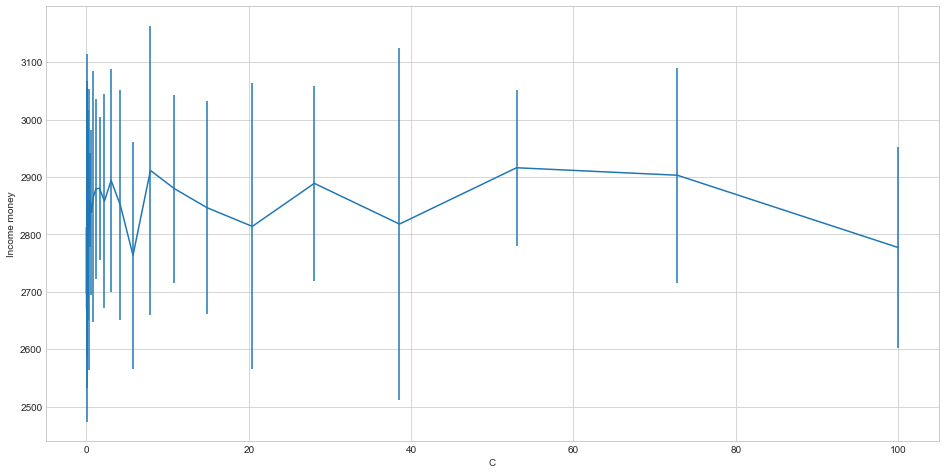

In [143]:
plt.figure(figsize=(16, 8))
plt.ylabel("Income money")
plt.xlabel("С")
plt.errorbar(C, incs, sdf)
plt.show()

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [52]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [53]:
#your code here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [54]:
#your code here

Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [55]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ гIалмакх чай

__Социализационный бонус (0.1 балл).__
Введены новые ограничения, занятия теперь дистанционные. Но это не значит, что не надо общаться с друзьями! Созвонитесь в зуме (или любым другим способом) хотя бы с двумя студентами курса МО-1 этого года, приложите скриншот созвона с включенными камерами и напишите очень кратко, на какие темы были беседы.

__Ответ:__
![](zoommeat.png)

Мы обсуждали инвестиции, а так же играли в крокодила